In [1]:
from astropy.table import Table, vstack, Column
from tqdm import tqdm
from astropy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import astropy.units as u
import seaborn as sns
from scipy.stats import ks_2samp
from matplotlib.lines import Line2D

In [2]:
decals_raw = Table.read('GalfitM_DECALS_183.csv', format='ascii')
decals = decals_raw[decals_raw['type_1'] != 'PSF']

control_sample = Table.read('/home/seba/Documents/MorphoLS/Output_Catalogs/GalfitM_DECALS_Control_Sample_1300.csv', format='ascii')

# Convertir la tabla de astropy a un DataFrame de pandas
df = decals.to_pandas()

# Reemplazar valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertir de nuevo el DataFrame a una tabla de astropy
decals = Table.from_pandas(df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/seba/Documents/MorphoLS/Output_Catalogs/GalfitM_DECALS_Control_Sample_1300.csv'

In [3]:
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['e_n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['e_RE_' + filtro], errors = 'coerce')
    control_sample['n_' + filtro] = pd.to_numeric(control_sample['n_' + filtro], errors='coerce')
    control_sample['RE_' +filtro] = pd.to_numeric(control_sample['RE_' + filtro], errors = 'coerce')
    control_sample['e_n_' + filtro] = pd.to_numeric(control_sample['e_n_' + filtro], errors='coerce')
    control_sample['e_RE_' +filtro] = pd.to_numeric(control_sample['e_RE_' + filtro], errors = 'coerce')

/tmp/ipykernel_146953/1739054786.py:5: RuntimeWarning: invalid value encountered in subtract
  g_r_cs = cs_no_zero['mag_g'] - cs_no_zero['mag_r']
/tmp/ipykernel_146953/1739054786.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', shade=True, cbar=False)
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


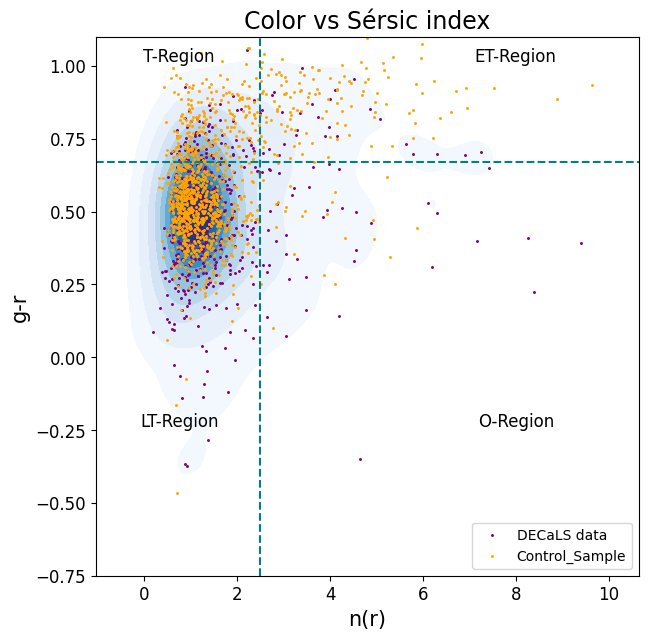

In [4]:
decals_no_zero = decals[decals['n_r']!=0.0]
g_r_decals = decals_no_zero['mag_g_2'] - decals_no_zero['mag_r_2']
n_r = decals_no_zero['n_r']
cs_no_zero = control_sample[control_sample['n_r'] != 0.0]
g_r_cs = cs_no_zero['mag_g'] - cs_no_zero['mag_r']
n_r_cs = cs_no_zero['n_r']
plt.figure(figsize=(7, 7))

sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', shade=True, cbar=False)
#sns.kdeplot(x=n_r_cs, y=g_r_cs, cmap='Oranges', shade=True, cbar=False)

plt.scatter(decals_no_zero['n_r'], g_r_decals, marker='.', label='DECaLS data', s=5, color='purple')
plt.scatter(cs_no_zero['n_r'], g_r_cs, marker='.', label='Control_Sample', s=5, color='orange')

plt.ylim(-0.75, 1.1)
#plt.xlim(0, )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('g-r', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='lower right')
plt.axhline(y=0.67, color='teal', linestyle='--')

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='teal', linestyle='--')

# Agregar texto en coordenadas específicas
plt.text(0.75, 1, 'T-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=12, ha='center', va='bottom', color='black')

plt.show()

In [5]:
sfr_decals = Table.read('sfr_decals.csv', format='ascii')
sfr_decals.rename_column('log(M_stellar)', 'stellar_mass')
sfr_decals.rename_column('logSFR_NUV', 'log_SFR')
sfr_decals.rename_column('Group_1', 'Group')
sfr_decals.rename_column('Gal_1', 'Gal')
sfr_decals.rename_column('zmemb', 'z')
sfr_decals.rename_column('ra_1', 'ra')
sfr_decals.rename_column('dec_1', 'dec')

type_column = Column(['SFCG Galaxy'] * len(sfr_decals), name='Nature')
sfr_decals.add_column(type_column)

In [6]:
type_column_cs = Column(['Field Galaxy'] * len(control_sample), name='Nature')
control_sample.add_column(type_column_cs)

In [35]:
sfr_decals_plots = sfr_decals['Group', 'Gal', 'z', 'ra', 'dec', 'log_SFR', 'stellar_mass', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature']
control_sample_plots = control_sample['Group', 'Gal', 'z', 'ra', 'dec', 'log_SFR', 'stellar_mass', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'Nature']

cg_cs = vstack([sfr_decals_plots, control_sample_plots])

In [66]:
cg_cs = cg_cs[cg_cs['log_SFR'] > -10]
cg_cs['log_sSFR'] = cg_cs['log_SFR'] - cg_cs['stellar_mass']
cg_cs['RE_g'] = cg_cs['RE_g']*0.262
cg_cs['RE_r'] = cg_cs['RE_r']*0.262
cg_cs['RE_i'] = cg_cs['RE_i']*0.262
cg_cs['RE_z'] = cg_cs['RE_z']*0.262

cg_cs['Distance (Mpc)'] = 300000*cg_cs['z']/67.4
cg_cs['RE_g(kpc)'] = (cg_cs['RE_g']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_r(kpc)'] = (cg_cs['RE_r']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_i(kpc)'] = (cg_cs['RE_i']*cg_cs['Distance (Mpc)'])/206.265
cg_cs['RE_z(kpc)'] = (cg_cs['RE_z']*cg_cs['Distance (Mpc)'])/206.265


cg_cs

Group,Gal,z,ra,dec,log_SFR,stellar_mass,RE_g,n_g,RE_r,n_r,RE_i,n_i,RE_z,n_z,Nature,log_sSFR,Distance (Mpc),RE_g(kpc),RE_r(kpc),RE_i(kpc),RE_z(kpc)
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str12,float64,float64,float64,float64,float64,float64
2,1,0.018646,0.3129815262621921,13.11314170389291,-0.2789290591480835,9.473105776138336,0.6575917961192,1.1081,0.6522341456480001,1.0998,0.0,0.0,0.6415853881992002,1.0833,SFCG Galaxy,-9.75203483528642,82.99406528189911,0.26459271546776325,0.2624369779797533,0.0,0.2581522778567232
2,4,0.017532,0.3732407814035215,13.09852691955251,-0.7453174949538912,8.58370314033253,1.725445811956,2.319,1.4628633877376003,1.9545,0.0,0.0,0.9411138391480002,1.2303,SFCG Galaxy,-9.32902063528642,78.03560830860533,0.6527826511503256,0.5534406435143666,0.0,0.3560487282164262
3,2,0.041719,2.837759217243158,-53.98101274211389,-0.17123263914445275,9.423748996141963,0.14318001655360002,0.7598,0.1396550098656,0.8373,0.1362900672568,0.9113,0.13264995830960002,0.9913,SFCG Galaxy,-9.594981635286416,185.6928783382789,0.1288997619293647,0.12572632660075148,0.12269699114165182,0.11941993343496145
3,4,0.041719,2.852407391719842,-53.9310223008958,0.7400473608555451,10.660135696141962,0.6522341456480001,0.9882,0.7092978891192001,1.5277,0.7637448546664001,2.0424,0.8226844052680001,2.5997,SFCG Galaxy,-9.920088335286417,185.6928783382789,0.587182681772891,0.6385550948043035,0.6875717178341179,0.7406328518082568
3,3,0.041719,2.842623280146343,-53.953910753132,-0.18691263914445244,8.709752796141961,0.2337780838536,0.6455,0.2269294994312,0.8063,0.22039564774880002,0.9598,0.21332225422640003,1.1259,SFCG Galaxy,-8.896665435286414,185.6928783382789,0.21046190717369648,0.2042963756781051,0.19841418662256852,0.19204626766979518
3,1,0.041719,2.834674521202194,-53.95652455274381,-0.5272326391444544,8.660981796141963,0.1083777694008,1.2663,0.11318688566800002,1.2493,0.11777478978080001,1.2331,0.12274037318160001,1.2155,SFCG Galaxy,-9.188214435286417,185.6928783382789,0.09756856445793906,0.10189803694197566,0.10602836016814521,0.11049869432238044
10,4,0.051799,5.687584604767833,-20.58857817827894,0.8068623322841653,10.473252367570579,0.4490049207752001,0.8662,0.43327547766640007,1.0386,0.4182690206232001,1.2031,0.4020234158208001,1.3812,SFCG Galaxy,-9.666390035286414,230.55934718100886,0.5018897118512144,0.4843076201987976,0.46753366950730835,0.44937462149721447
10,1,0.051799,5.653417994681938,-20.57092018426899,0.0803023322841625,9.452381967570577,0.09288752317440001,0.7873,0.0846199437128,0.9068,0.076731842012,1.0208,0.0681908946848,1.1443,SFCG Galaxy,-9.372079635286415,230.55934718100886,0.10382802077109786,0.09458666754377565,0.0857694878058955,0.0762225688421032
10,3,0.051799,5.674201525891037,-20.58429908579907,0.3485423322841612,9.318693467570576,0.32930396662559996,1.7285,0.3259677995816,1.8452,0.32278630119840007,1.9566,0.3193404273136001,2.0773,SFCG Galaxy,-8.970151135286415,230.55934718100886,0.36809011499437644,0.36436100682890277,0.36080478454064246,0.35695304802040123


In [67]:
cg_cs = cg_cs[cg_cs['RE_g(kpc)'] < 30]
cg_cs

Group,Gal,z,ra,dec,log_SFR,stellar_mass,RE_g,n_g,RE_r,n_r,RE_i,n_i,RE_z,n_z,Nature,log_sSFR,Distance (Mpc),RE_g(kpc),RE_r(kpc),RE_i(kpc),RE_z(kpc)
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str12,float64,float64,float64,float64,float64,float64
2,1,0.018646,0.3129815262621921,13.11314170389291,-0.2789290591480835,9.473105776138336,0.6575917961192,1.1081,0.6522341456480001,1.0998,0.0,0.0,0.6415853881992002,1.0833,SFCG Galaxy,-9.75203483528642,82.99406528189911,0.26459271546776325,0.2624369779797533,0.0,0.2581522778567232
2,4,0.017532,0.3732407814035215,13.09852691955251,-0.7453174949538912,8.58370314033253,1.725445811956,2.319,1.4628633877376003,1.9545,0.0,0.0,0.9411138391480002,1.2303,SFCG Galaxy,-9.32902063528642,78.03560830860533,0.6527826511503256,0.5534406435143666,0.0,0.3560487282164262
3,2,0.041719,2.837759217243158,-53.98101274211389,-0.17123263914445275,9.423748996141963,0.14318001655360002,0.7598,0.1396550098656,0.8373,0.1362900672568,0.9113,0.13264995830960002,0.9913,SFCG Galaxy,-9.594981635286416,185.6928783382789,0.1288997619293647,0.12572632660075148,0.12269699114165182,0.11941993343496145
3,4,0.041719,2.852407391719842,-53.9310223008958,0.7400473608555451,10.660135696141962,0.6522341456480001,0.9882,0.7092978891192001,1.5277,0.7637448546664001,2.0424,0.8226844052680001,2.5997,SFCG Galaxy,-9.920088335286417,185.6928783382789,0.587182681772891,0.6385550948043035,0.6875717178341179,0.7406328518082568
3,3,0.041719,2.842623280146343,-53.953910753132,-0.18691263914445244,8.709752796141961,0.2337780838536,0.6455,0.2269294994312,0.8063,0.22039564774880002,0.9598,0.21332225422640003,1.1259,SFCG Galaxy,-8.896665435286414,185.6928783382789,0.21046190717369648,0.2042963756781051,0.19841418662256852,0.19204626766979518
3,1,0.041719,2.834674521202194,-53.95652455274381,-0.5272326391444544,8.660981796141963,0.1083777694008,1.2663,0.11318688566800002,1.2493,0.11777478978080001,1.2331,0.12274037318160001,1.2155,SFCG Galaxy,-9.188214435286417,185.6928783382789,0.09756856445793906,0.10189803694197566,0.10602836016814521,0.11049869432238044
10,4,0.051799,5.687584604767833,-20.58857817827894,0.8068623322841653,10.473252367570579,0.4490049207752001,0.8662,0.43327547766640007,1.0386,0.4182690206232001,1.2031,0.4020234158208001,1.3812,SFCG Galaxy,-9.666390035286414,230.55934718100886,0.5018897118512144,0.4843076201987976,0.46753366950730835,0.44937462149721447
10,1,0.051799,5.653417994681938,-20.57092018426899,0.0803023322841625,9.452381967570577,0.09288752317440001,0.7873,0.0846199437128,0.9068,0.076731842012,1.0208,0.0681908946848,1.1443,SFCG Galaxy,-9.372079635286415,230.55934718100886,0.10382802077109786,0.09458666754377565,0.0857694878058955,0.0762225688421032
10,3,0.051799,5.674201525891037,-20.58429908579907,0.3485423322841612,9.318693467570576,0.32930396662559996,1.7285,0.3259677995816,1.8452,0.32278630119840007,1.9566,0.3193404273136001,2.0773,SFCG Galaxy,-8.970151135286415,230.55934718100886,0.36809011499437644,0.36436100682890277,0.36080478454064246,0.35695304802040123


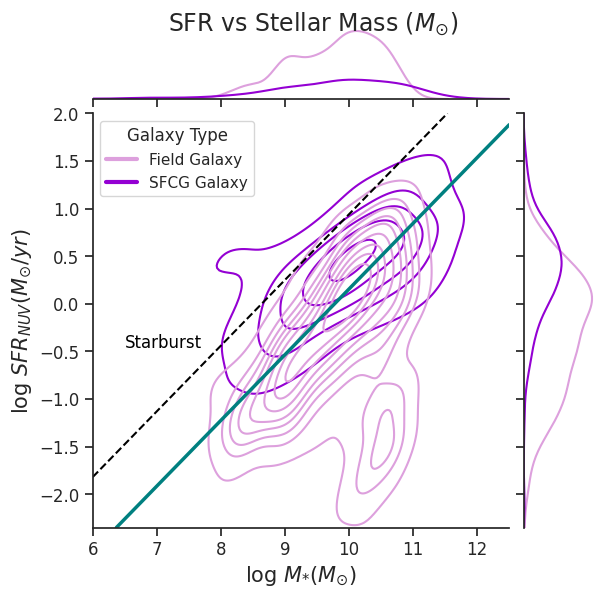

In [58]:
custom_palette = {'Field Galaxy': 'plum', 'SFCG Galaxy': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=cg_cs['log_SFR']
x=cg_cs['stellar_mass']
sur=cg_cs['Nature']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=cg_cs,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)
# Añadir un título al gráfico
g.fig.suptitle("SFR vs Stellar Mass $(M_{\odot})$", fontsize=17)
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga con el gráfico

# Añadir una recta que pase por el punto (x, y) = (0.25, 0.25)
g.ax_joint.axline((9, 0.25), slope=0.69, color='black', linestyle='--')
# Limitar los ejes
g.ax_joint.set_xlim(6, 12.5)
g.ax_joint.set_ylim(-2.35, 2)
g.ax_joint.text(6.5, -0.5, 'Starburst', color='black', fontsize=12, verticalalignment='bottom')
# Añadir una segunda recta continua con un label
g.ax_joint.axline((10.5, 0.5), slope=0.69, color='teal', linestyle='-', label='Main sequence, Sargent+14', linewidth=2.5)
g.set_axis_labels("log $M_{*} (M_{\odot})$", "log $SFR_{NUV} (M_{\odot}/yr)$", fontsize=15)
g.ax_joint.tick_params(axis='both', labelsize=12)  # Cambia 12 por el tamaño de fuente deseado
# Mostrar la leyenda con el label de la recta continua
g.ax_joint.legend()

# Definir los handles y labels
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda al gráfico
g.ax_joint.legend(handles=handles, labels=labels, title="Galaxy Type", loc="upper left")

plt.show()

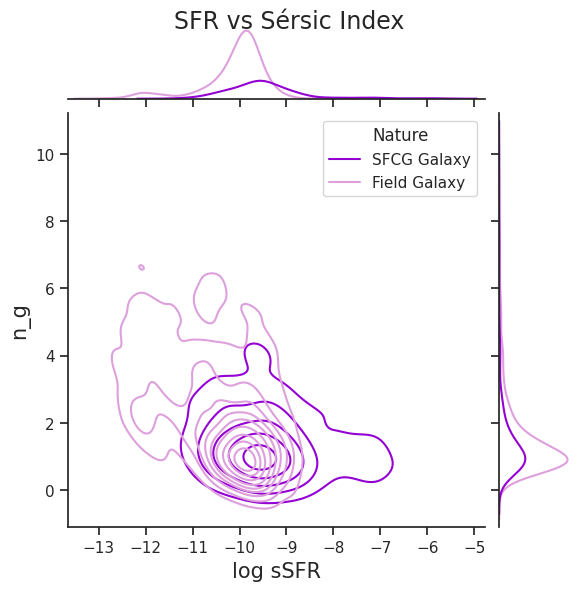

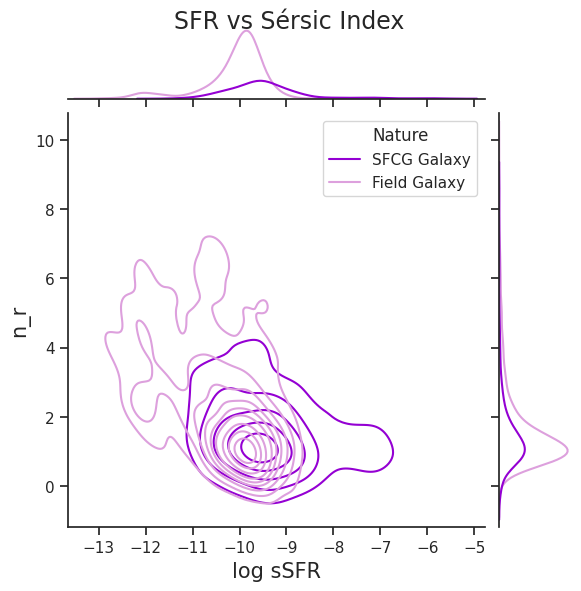

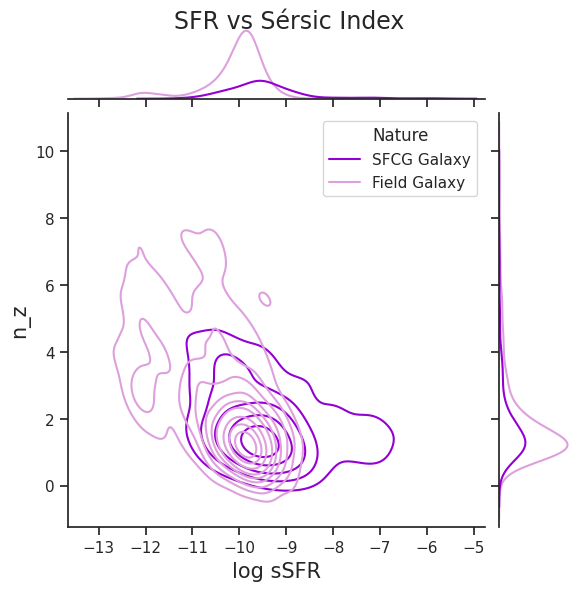

In [68]:
import warnings

# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'plum', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['n_g', 'n_r', 'n_z']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    
    # Añadir títulos
    g.set_axis_labels("log sSFR", f"{col}", fontsize=15)
    g.fig.suptitle(f"SFR vs Sérsic Index", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()


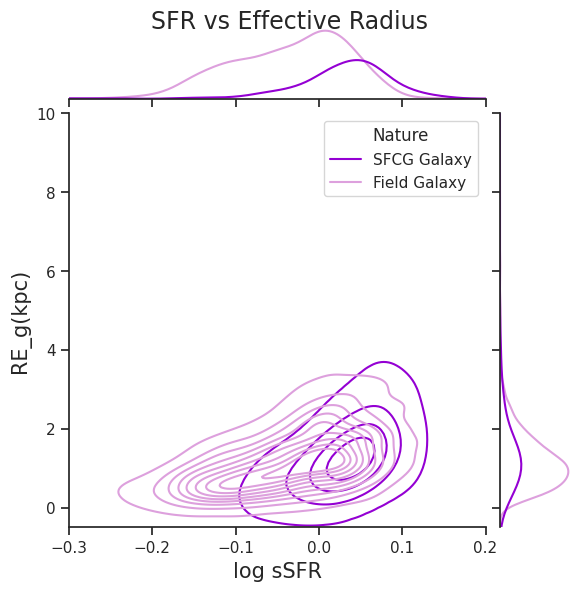

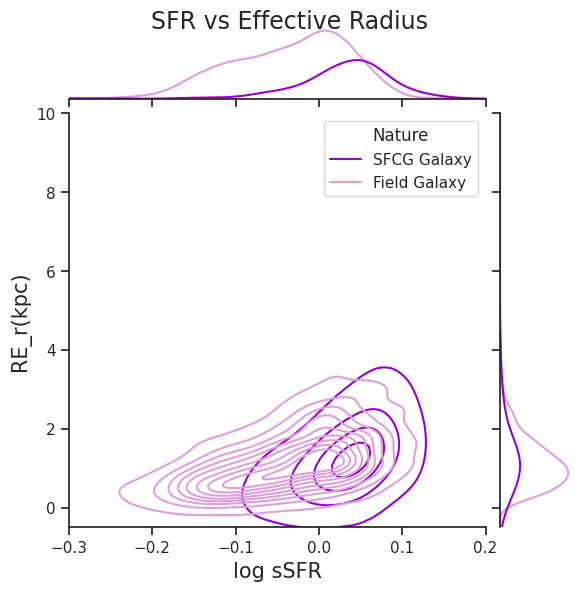

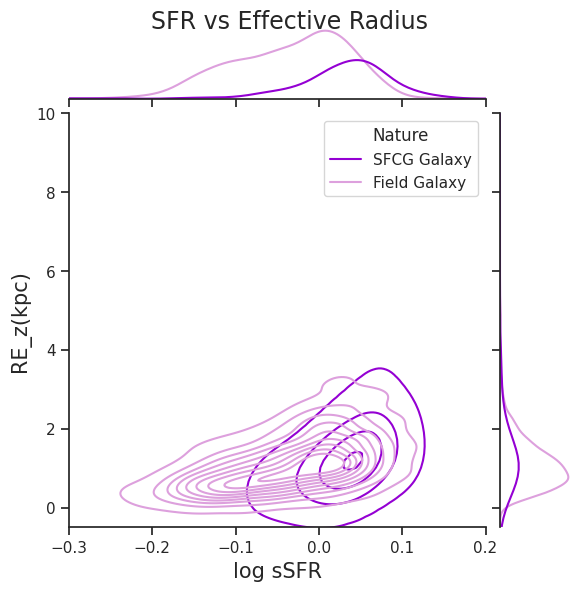

In [65]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Field Galaxy': 'plum', 'SFCG Galaxy': 'darkviolet'}

# Definir los datos
x = cg_cs['log_sSFR']
sur = cg_cs['Nature']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    # Crear el gráfico
    g = sns.jointplot(
        data=cg_cs,
        x=x, y=cg_cs[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # No llenar las curvas
        palette=custom_palette
    )
    # Limitar los ejes
    g.ax_joint.set_xlim(-0.3, 0.2)
    g.ax_joint.set_ylim(-0.5, 10)
    # Añadir títulos
    g.set_axis_labels("log sSFR", f"{col}", fontsize=15)
    g.fig.suptitle(f"SFR vs Effective Radius", fontsize=17)  # Título principal
    g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga

    # Mostrar el gráfico
    plt.show()